# Fashion MNIST with SciKit-Learn and skorch

In [ ]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch'])
except ImportError:
    pass

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

## Loading Data

In [ ]:
mnist = fetch_openml('Fashion-MNIST', as_frame=False, cache=False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
mnist.data.shape

(70000, 784)

## Preprocessing Data


In [ ]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

In [ ]:
X /= 255.0

In [ ]:
X.min(), X.max()

(0.0, 1.0)

Note: data is not normalized.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [ ]:
X_train.shape, y_train.shape

((52500, 784), (52500,))

### Print a selection of training images and their labels

In [ ]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

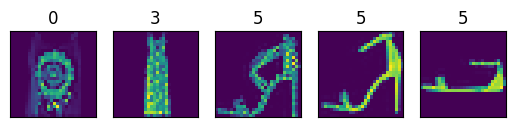

In [ ]:
plot_example(X_train, y_train)

## Build Neural Network with PyTorch

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
mnist_dim = X.shape[1]
hidden_dims = [int(mnist_dim/8)]
output_dim = len(np.unique(mnist.target))

In [ ]:
mnist_dim, hidden_dims, output_dim

(784, [98], 10)

In [ ]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dims=hidden_dims,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden = nn.ModuleList()
        for i in range(len(hidden_dims)):
            if i == 0:
              self.hidden.append(nn.Linear(mnist_dim, hidden_dims[i]))
            else:
              self.hidden.append(nn.Linear(hidden_dims[i - 1], hidden_dims[i]))
        self.output = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, X, eval=False, **kwargs):
        Ts = None
        layers = None
        layer_num = 0
        for h in self.hidden:
          X = F.relu(h(X))
          if eval:
            Ts = torch.cat((Ts, X), 1) if Ts is not None else X
            l = torch.ones_like(X) * layer_num
            layers = torch.cat((layers, l), 1) if layers is not None else l
          layer_num += 1
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        if eval:
          return X, Ts, layers
        return X

In [ ]:
from skorch import NeuralNetClassifier
nets = []

In [ ]:
torch.manual_seed(0)

net1 = NeuralNetClassifier(
    ClassifierModule(mnist_dim, [100], output_dim),
    max_epochs=20,
    lr=0.1,
    device=device,
)

In [ ]:
net1.fit(X_train, y_train);
nets.append(net1)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9335       0.7359        0.6875  2.2765
      2        0.6190       0.7488        0.6166  2.2336
      3        0.5546       0.8241        0.4889  1.7545
      4        0.5163       0.8153        0.4946  1.7518
      5        0.4953       0.8270        0.4674  2.1016
      6        0.4776       0.8382        0.4376  2.1092
      7        0.4657       0.8145        0.4720  1.9089
      8        0.4569       0.8012        0.4983  3.1471
      9        0.4468       0.8256        0.4512  1.9625
     10        0.4373       0.8455        0.4122  2.5142
     11        0.4337       0.8429        0.4181  1.4887
     12        0.4244       0.8247        0.4464  0.9453
     13        0.4193       0.8476        0.4107  0.9297
     14        0.4153       0.8570        0.3922  0.9499
     15        0.4104       0.8574        0.3839  1.0585
     16        0.4047       0.8

In [ ]:
net1.module.forward(torch.tensor(X_test).to(device),eval=True)

(tensor([[1.1801e-04, 5.5010e-04, 7.7350e-01,  ..., 8.0221e-09, 5.9632e-04,
          3.0549e-07],
         [3.1447e-07, 1.0455e-07, 2.1085e-07,  ..., 9.9671e-01, 1.9299e-04,
          1.0647e-05],
         [5.8427e-01, 1.5919e-02, 2.9157e-03,  ..., 7.5533e-07, 1.1539e-03,
          6.2748e-06],
         ...,
         [2.0115e-06, 1.6654e-06, 9.8200e-03,  ..., 3.3027e-11, 5.1383e-05,
          7.7709e-09],
         [2.7254e-05, 9.9997e-01, 4.1435e-08,  ..., 9.7972e-11, 1.7783e-10,
          1.3181e-10],
         [1.9633e-07, 8.5795e-08, 1.6513e-07,  ..., 9.8580e-01, 1.5568e-04,
          4.7028e-05]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor([[1.0005, 0.6328, 1.8747,  ..., 0.0000, 0.0000, 0.2108],
         [0.6530, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.9999],
         [1.1237, 0.6099, 2.1949,  ..., 0.9265, 0.7015, 0.0481],
         ...,
         [0.6884, 0.7608, 2.8408,  ..., 0.0000, 0.0000, 1.7168],
         [2.6313, 0.0000, 2.9877,  ..., 2.8201, 1.0601, 0.0000],
      

In [ ]:
y_pred = net1.predict(X_test)
accuracy_score(y_test, y_pred)

0.8681142857142857

In [ ]:
hidden_dims = [60, 40]
net2 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net2.fit(X_train, y_train);
nets.append(net2)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2109       0.6453        0.8895  1.0391
      2        0.7902       0.5770        1.0472  1.0056
      3        0.7161       0.7691        0.6223  1.0079
      4        0.6498       0.7240        0.6439  1.0022
      5        0.6071       0.7945        0.5513  0.9942
      6        0.5753       0.8278        0.4553  1.0098
      7        0.5515       0.7891        0.5538  1.2789
      8        0.5292       0.8286        0.4593  1.4455
      9        0.5095       0.8023        0.5056  1.0974
     10        0.4912       0.8114        0.4982  1.0075
     11        0.4830       0.8323        0.4477  1.0051
     12        0.4715       0.8374        0.4292  0.9940
     13        0.4614       0.8381        0.4430  0.9909
     14        0.4535       0.7677        0.5746  0.9858
     15        0.4454       0.8221        0.4627  0.9939
     16        0.4333       0.8

In [ ]:
y_pred = net2.predict(X_test)
accuracy_score(y_test, y_pred)

0.8242285714285714

In [ ]:
hidden_dims = [40, 60]
net3 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net3.fit(X_train, y_train);
nets.append(net3)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1003       0.6938        0.7909  1.0206
      2        0.6983       0.7576        0.6256  1.0462
      3        0.6160       0.7432        0.6171  1.0133
      4        0.5703       0.7693        0.6060  1.0121
      5        0.5364       0.7675        0.6092  1.0046
      6        0.5145       0.8191        0.4873  1.0252
      7        0.4981       0.8253        0.4625  1.0211
      8        0.4840       0.8279        0.4911  1.0201
      9        0.4702       0.8282        0.4651  0.9847
     10        0.4626       0.8348        0.4701  1.2179
     11        0.4477       0.8158        0.5299  1.3938
     12        0.4376       0.8209        0.4755  1.0864
     13        0.4334       0.7740        0.5545  0.9896
     14        0.4263       0.8390        0.4351  1.0082
     15        0.4205       0.8377        0.4283  1.0076
     16        0.4148       0.8

In [ ]:
y_pred = net3.predict(X_test)
accuracy_score(y_test, y_pred)

0.8237714285714286

In [ ]:
error_mask = y_pred != y_test

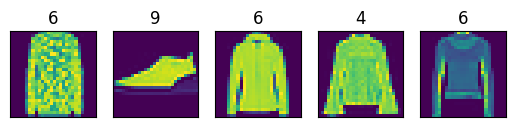

In [ ]:
plot_example(X_test[error_mask], y_pred[error_mask])

In [ ]:
[mnist_dim//4, mnist_dim//2]

[196, 392]

In [ ]:
hidden_dims = [50, 50]
net4 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net4.fit(X_train, y_train);
nets.append(net4)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1002       0.6804        0.7671  1.5382
      2        0.7087       0.7756        0.6172  1.1105
      3        0.6289       0.7841        0.5666  1.4193
      4        0.5822       0.8015        0.5204  3.2848
      5        0.5478       0.7976        0.5226  2.5135
      6        0.5253       0.8065        0.5153  1.7045
      7        0.5073       0.8070        0.5127  2.2682
      8        0.4934       0.8336        0.4498  1.9802
      9        0.4761       0.8350        0.4430  1.0232
     10        0.4652       0.7644        0.6547  1.0358
     11        0.4574       0.7932        0.5158  1.3292
     12        0.4486       0.8159        0.4731  1.6066
     13        0.4373       0.7983        0.4862  1.4027
     14        0.4305       0.8139        0.4825  1.3010
     15        0.4186       0.8450        0.4169  1.0297
     16        0.4208       0.7

In [ ]:
y_pred = net4.predict(X_test)
accuracy_score(y_test, y_pred)

0.8088

In [ ]:
hidden_dims = [20, 20, 20, 20, 20]
net5 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net5.fit(X_train, y_train);
nets.append(net5)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2627       0.2017        1.9843  1.3073
      2        1.6617       0.4955        1.3683  1.6114
      3        1.2950       0.4944        1.2156  1.3194
      4        1.1810       0.5719        1.0716  1.1631
      5        1.1209       0.6303        0.8899  1.2270
      6        1.0598       0.4847        1.4796  1.1917
      7        1.0453       0.4505        2.1787  1.6391
      8        1.1537       0.5924        0.8623  1.1809
      9        0.9558       0.6217        0.9961  1.2595
     10        0.9605       0.6226        0.9394  1.1691
     11        0.8907       0.6676        0.9170  1.5938
     12        0.8638       0.7229        0.7566  1.4762
     13        0.8276       0.7027        0.7536  1.2455
     14        0.8025       0.6999        0.6762  1.2327
     15        0.7936       0.7106        0.7675  1.2130
     16        0.7888       0.7

In [ ]:
y_pred = net5.predict(X_test)
accuracy_score(y_test, y_pred)

0.7777714285714286

In [ ]:
def get_correlation(module1, module2, X):
  Ts1, layers1 = module1.forward(X, eval=True)[1], module1.forward(X, eval=True)[2]
  Ts2, layers2 = module2.forward(X, eval=True)[1], module2.forward(X, eval=True)[2]

  correlations = np.zeros_like(Ts1.cpu().detach().numpy()[0])
  for i in range(Ts1.shape[1]):
    neuron_i = Ts1[:, i]
    max_idx = 0
    max_corr = -1
    for j in range(Ts2.shape[1]):
      neuron_j = Ts2[:, j]
      stacked = torch.stack((neuron_i, neuron_j))
      corr = torch.corrcoef(stacked)[0, 1] / (abs(layers1[0, i] - layers2[0, j]) + 1)
      corr = corr.cpu().detach().numpy()
      if corr > max_corr:
        max_corr = corr
        max_idx = j
    correlations[i] = max_corr

  return correlations.mean()

def mean_correlation(module1, module2, X):
    return (get_correlation(module1, module2, X) + get_correlation(module2, module1, X)) / 2

In [ ]:
for i in range(len(nets)):
  for j in range(i + 1, len(nets)):
    correlation = get_correlation(nets[i].module, nets[j].module, torch.tensor(X_test).to(device))
    print("correlation between net" + str(i + 1) + " and net" + str(j + 1) + ":", correlation)

correlation between net1 and net2: 0.6841235
correlation between net1 and net3: 0.6663947
correlation between net1 and net4: 0.6706339
correlation between net1 and net5: 0.6143566
correlation between net2 and net3: 0.7243448
correlation between net2 and net4: 0.7242228
correlation between net2 and net5: 0.664303
correlation between net3 and net4: 0.7474202
correlation between net3 and net5: 0.6392411
correlation between net4 and net5: 0.6042386


# Convolutional Network


In [ ]:
XCnn = X.reshape(-1, 1, 28, 28)

In [ ]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x, eval=False):

        outputs = []
        x = x.reshape((x.shape[0], 1, 28, 28))

        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        outputs.append(x)
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        outputs.append(x)

        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))

        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)

        Ts = None
        layers = None
        layer_num = 0
        if eval:
          for X in outputs:
            X = X.reshape((X.shape[0], np.prod(X.shape) // X.shape[0]))
            Ts = torch.cat((Ts, X), 1) if Ts is not None else X
            l = torch.ones_like(X) * layer_num
            layers = torch.cat((layers, l), 1) if layers is not None else l
            layer_num += 1
          return x, Ts, layers

        return x


In [ ]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn(),
    max_epochs=10,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

In [ ]:
cnn.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7696       0.8181        0.4822  2.5088
      2        0.5248       0.8485        0.4088  1.6183
      3        0.4647       0.8738        0.3535  1.6279
      4        0.4256       0.8761        0.3385  1.6277
      5        0.4046       0.8820        0.3217  1.5999
      6        0.3864       0.8842        0.3157  1.6119
      7        0.3688       0.8911        0.2953  1.7551
      8        0.3616       0.8911        0.2979  2.0252
      9        0.3504       0.8936        0.2868  1.5754
     10        0.3380       0.8931        0.2845  1.6112


In [ ]:
y_pred = cnn.predict(X_test)
accuracy_score(y_test, y_pred)

0.8990857142857143

In [ ]:
X_test.shape

(17500, 784)

In [ ]:
for i in range(len(nets)):
  correlation = get_correlation(nets[i].module, cnn.module, torch.tensor(X_test[:10]).to(device))
  print("correlation between net" + str(i + 1) + " and cnn:", correlation)

correlation between net1 and cnn: 0.75602305
correlation between net2 and cnn: 0.8229956
correlation between net3 and cnn: 0.81979144
correlation between net4 and cnn: 0.7551918
correlation between net5 and cnn: 0.31736726
